# Sea Ice Extent Timeseries
## **SODA**

In [6]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [7]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.1079e8bb8a704963b486affb12791bf5 Dashboard: /services/dask-gateway/clusters/staging.1079e8bb8a704963b486affb12791bf5/status,Cluster Workers: 20 Cores: 40 Memory: 160.00 GiB


In [81]:
client.close()
cluster.close()

In [8]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
import xgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt

In [9]:
path = "s3://Pangeo/pangeo-forge/soda342/5day_ice.zarr"
mapper = fsspec.get_mapper(
    path, anon=True, client_kwargs={'endpoint_url': 'https://ncsa.osn.xsede.org'},
)
ds = xr.open_zarr(mapper, consolidated=True)

In [10]:
ds

<xarray.Dataset>
Dimensions:      (ct: 5, nv: 2, time: 2117, xb: 1441, xt: 1440, xv: 1440, yb: 1071, yt: 1070, yv: 1070)
Coordinates:
  * ct           (ct) float64 0.0 0.1 0.3 0.7 1.1
  * nv           (nv) float64 1.0 2.0
  * time         (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
  * xb           (xb) float64 -280.0 -279.8 -279.5 -279.3 ... 79.53 79.77 80.0
  * xt           (xt) float64 -279.9 -279.7 -279.4 -279.2 ... 79.42 79.65 79.88
  * xv           (xv) float64 -279.8 -279.5 -279.3 -279.1 ... 79.53 79.77 80.0
  * yb           (yb) float64 -80.07 -79.97 -79.86 -79.76 ... 78.84 78.85 78.85
  * yt           (yt) float64 -80.02 -79.92 -79.81 -79.7 ... 78.84 78.84 78.85
  * yv           (yv) float64 -79.97 -79.86 -79.76 -79.65 ... 78.84 78.85 78.85
Data variables:
    average_DT   (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1   (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2   (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    cn           (time, ct, yt, xt) float32 dask.array<chunksize=(1, 5, 1070, 1440), meta=np.ndarray>
    hi           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    hs           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    ix_trans     (time, yt, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    iy_trans     (time, yv, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    mi           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    time_bounds  (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    ui           (time, yv, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    vi           (time, yv, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
Attributes:
    filename:   soda3.4.2_5dy_ice_or_1992_01_05.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      MOM5_SODA_3.4.2

In [11]:
ds.cn

,Array,Chunk
Bytes,60.76 GiB,29.39 MiB
Shape,"(2117, 5, 1070, 1440)","(1, 5, 1070, 1440)"
Count,2118 Tasks,2117 Chunks
Type,float32,numpy.ndarray


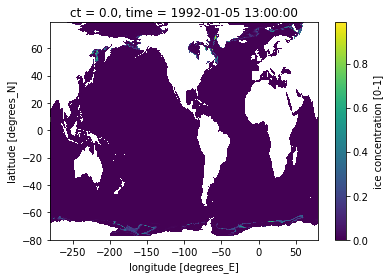

In [6]:
ds.cn[0,0].plot();

In [46]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  867 #-65.44282571
right_lon = 1228 #30.0427

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [47]:
#set the boundaries
lat_range = dict(yt=slice(lower_lat, upper_lat), yv=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt=slice(left_lon, right_lon), xv=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt=slice(left_lon, right_lon))

#lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
#lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [48]:
ds_wg = ds.isel(**lat_range, **lon_range)

In [49]:
ice = ds.cn.isel(**lat_range_no_u, **lon_range_no_u)
#ds_wg = ds.isel(**lat_range, **lon_range)

In [50]:
ice

,Array,Chunk
Bytes,2.41 GiB,1.16 MiB
Shape,"(2117, 5, 169, 361)","(1, 5, 169, 361)"
Count,4235 Tasks,2117 Chunks
Type,float32,numpy.ndarray


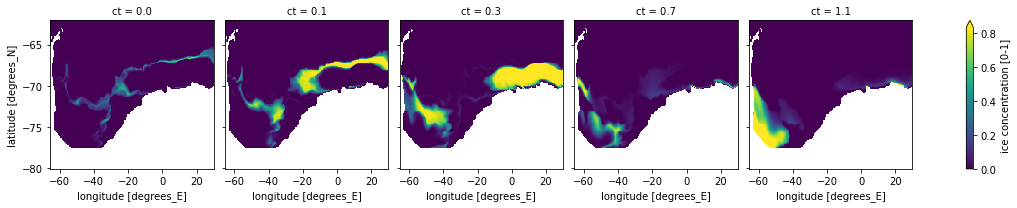

In [51]:
ice.isel(time=0,ct=[0,1,2,3,4]).plot(robust=True, col='ct');

In [96]:
ice.ct[2]

<xarray.DataArray 'ct' ()>
array(0.3)
Coordinates:
    ct       float64 0.3
Attributes:
    cartesian_axis:  Z
    long_name:       thickness
    units:           meters

In [137]:
#999 is ocean, 111 is land
mask = ice.where(ice == ice.notnull(), 999).where(ice < 999, 111)

In [138]:
mask

,Array,Chunk
Bytes,2.41 GiB,1.16 MiB
Shape,"(2117, 5, 169, 361)","(1, 5, 169, 361)"
Count,16937 Tasks,2117 Chunks
Type,float32,numpy.ndarray


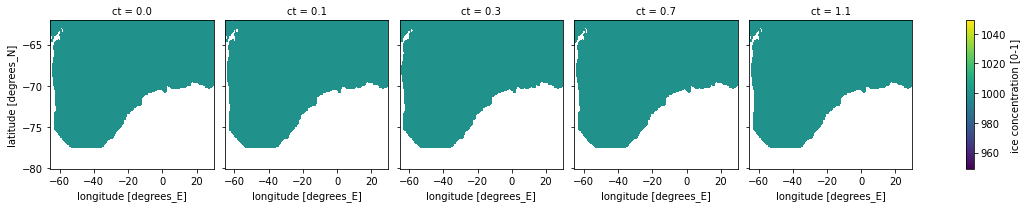

In [139]:
mask.where(mask == 999).isel(time=0,ct=[0,1,2,3,4]).plot(robust=True, col='ct');

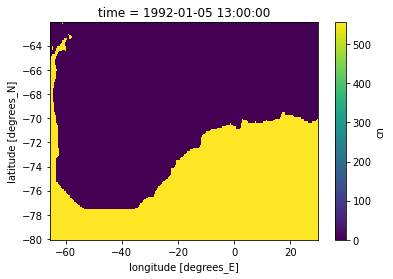

In [149]:
mask.where(mask == 111).sum('ct')[0].plot()

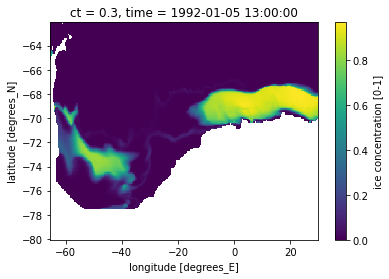

In [93]:
ice.isel(time=0, ct=2).plot()

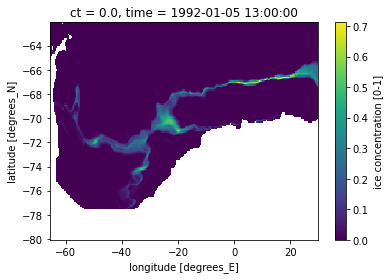

In [107]:
ice[0,0].plot()

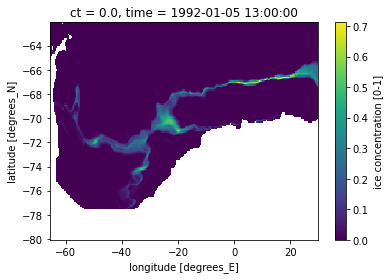

In [135]:
ice.where(mask == 999)[0,0].plot()

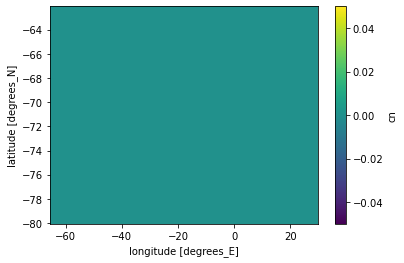

In [161]:
mask.where(mask == 111).sum('ct').std(dim='time').plot()

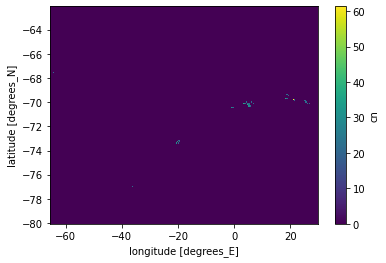

In [162]:
mask.where(mask == 999).sum('ct').std(dim='time').plot()

In [207]:
land = mask.where(mask == 999).sum('ct')[0]

In [209]:
land

<xarray.DataArray 'cn' (yt: 169, xt: 361)>
dask.array<getitem, shape=(169, 361), dtype=float32, chunksize=(169, 361), chunktype=numpy.ndarray>
Coordinates:
    time     object 1992-01-05 13:00:00
  * xt       (xt) float64 -65.44 -65.21 -64.97 -64.73 ... 29.06 29.31 29.55 29.8
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

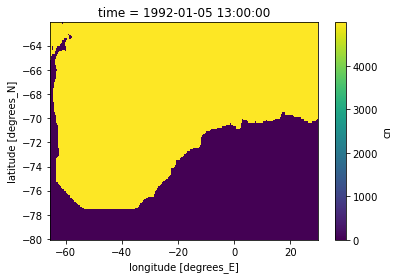

In [208]:
land.plot()

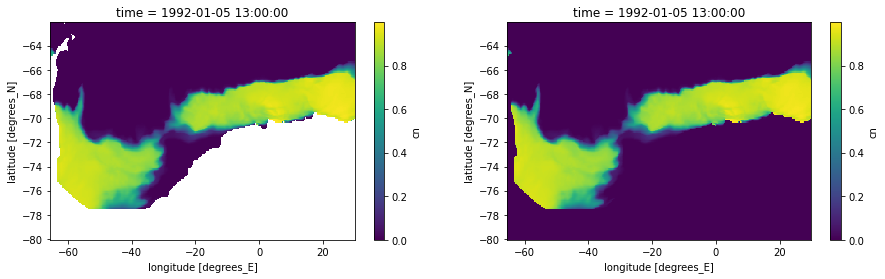

In [216]:
#values are slightly different with the mask. More yellow in plot without mask
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))

ice.sum('ct')[0].where(land).plot(ax=ax0)
ice.sum('ct')[0].plot(ax=ax1);

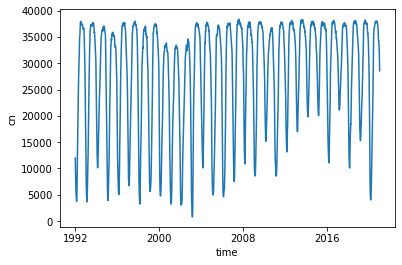

In [14]:
ice.sum(['ct', 'yt', 'xt']).plot();

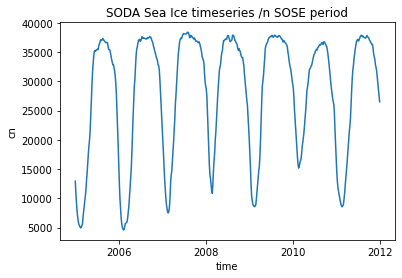

In [15]:
ice.sum(['ct', 'yt', 'xt']).sel(time=slice('2005', '2011')).plot()
plt.title('SODA Sea Ice timeseries /n SOSE period');

In [16]:
ice

,Array,Chunk
Bytes,2.54 GiB,1.23 MiB
Shape,"(2117, 5, 169, 381)","(1, 5, 169, 381)"
Count,4235 Tasks,2117 Chunks
Type,float32,numpy.ndarray


In [21]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [25]:
msi = ice.sum('ct').mean('time').load()

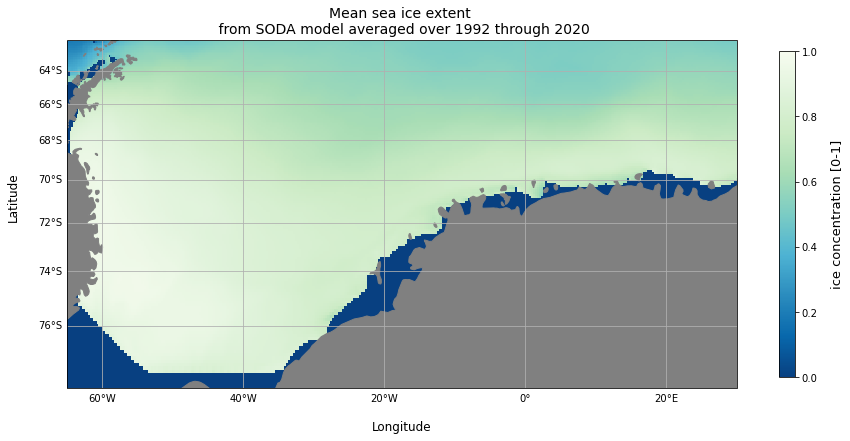

In [28]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ice.xt, ice.yt, msi, transform=ccrs.PlateCarree(), cmap='GnBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("ice concentration [0-1]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Mean sea ice extent \n from SODA model averaged over 1992 through 2020', fontsize=14);

## Saving Data

In [17]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [18]:
seaice_file = ice.to_dataset(name='seaice')

In [19]:
seaice_file

,Array,Chunk
Bytes,2.54 GiB,1.23 MiB
Shape,"(2117, 5, 169, 381)","(1, 5, 169, 381)"
Count,4235 Tasks,2117 Chunks
Type,float32,numpy.ndarray


In [20]:
#uploading wg region ice variable
gcsmap_seaice = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/seaice.zarr')
seaice_file.to_zarr(gcsmap_seaice, mode='w')